In [1]:
import sys 
from pathlib import Path
import torch
import os
import dill
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os
from pathlib import Path
import cv2
import time

sys.path.append("/home/franka_deoxys/diffusion_policy")
from diffusion_policy.workspace.base_workspace import BaseWorkspace
from diffusion_policy.model.common.rotation_transformer import RotationTransformer
from diffusion_policy.common.pytorch_util import dict_apply
from diffusion_policy.workspace.train_diffusion_unet_hybrid_workspace import TrainDiffusionUnetHybridWorkspace


sys.path.append("/home/franka_deoxys/deoxys_control/deoxys")
from deoxys import config_root
from deoxys.franka_interface import FrankaInterface
from deoxys.utils import  YamlConfig
from deoxys.utils.config_utils import robot_config_parse_args
from deoxys.utils.input_utils import input2action
from deoxys.utils.io_devices import SpaceMouse
from deoxys.utils.log_utils import get_deoxys_example_logger
from deoxys.experimental.motion_utils import follow_joint_traj, reset_joints_to

sys.path.append("/home/franka_deoxys/deoxys_vision")
from deoxys_vision.networking.camera_redis_interface import CameraRedisSubInterface
from deoxys_vision.utils.camera_utils import assert_camera_ref_convention, get_camera_info


from util_eval import RobotStateRawObsDictGenerator, FrameStackForTrans

np.set_printoptions(precision=3, suppress=True)

logger = get_deoxys_example_logger()

/home/franka_deoxys/miniconda3/envs/robodiff_2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
args = robot_config_parse_args()
robot_interface = FrankaInterface(os.path.join(config_root, args.interface_cfg))
controller_cfg = YamlConfig(
    os.path.join(config_root, args.controller_cfg)
).as_easydict()
controller_type = args.controller_type



In [ ]:
# spacemouse = SpaceMouse(vendor_id=9583, product_id=50734) 
#old spacemoue not wireless
spacemouse = SpaceMouse(vendor_id=9583, product_id=50770)
spacemouse.start_control()
raw_obs_dict_generator = RobotStateRawObsDictGenerator()

Opening SpaceMouse device
Manufacturer: 3Dconnexion
Product: 3Dconnexion Universal Receiver

Control                       	Command
Right button                  	reset simulation
Left button (hold)            	close gripper
Move mouse laterally          	move arm horizontally in x-y plane
Move mouse vertically         	move arm vertically
Twist mouse about an axis     	rotate arm about a corresponding axis
ESC                           	quit



In [ ]:
def set_gripper(open=True):
    d=-1. if open else 1.0
    action_close=np.array([ 0.,  0., -0.,  0.,  0., -0., d])
    robot_interface.control(
        controller_type=controller_type,
        action=action_close,
        controller_cfg=controller_cfg,
    )

In [ ]:
if robot_interface._state_buffer:
    last_state = robot_interface._state_buffer[-1]
else:
    print("The state buffer is empty.")
    

In [ ]:
camera_ids = [0,1]
# camera_ids = [0]
cr_interfaces = {}

use_depth = False
for camera_id in camera_ids:
    camera_ref=f"rs_{camera_id}"
    assert_camera_ref_convention(camera_ref)
    camera_info = get_camera_info(camera_ref)
    print('---------****-----------')
    print(camera_info)
    print('--------------------------')
    # camera_info=  {'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'}
# 

    cr_interface = CameraRedisSubInterface(camera_info=camera_info, use_depth=use_depth, redis_host='127.0.0.1')
    cr_interface.start()
    cr_interfaces[camera_id] = cr_interface


def get_imgs(use_depth=False):
    data = {}
    for camera_id in camera_ids:
        img_info = cr_interfaces[camera_id].get_img_info()
        data[f"camera_{camera_id}"]=img_info

        imgs = cr_interfaces[camera_id].get_img()
    
        color_img = imgs["color"][..., ::-1]
        
        # color_img = cv2.resize(color_img, (128, 128))  
        # depth_img = cv2.resize(depth_img, (128, 128))
        
        # color_img = cv2.resize(color_img, ) 


        # color_img = cv2.resize(color_img, (224, 224), fx=0.5, fy=0.5)

        color_img = cv2.resize(color_img, (320, 240))

        data[f"camera_{camera_id}_color"]=color_img

        if use_depth:
            depth_img = imgs["depth"]
            depth_img = cv2.resize(depth_img, (224, 224)) 
            data[f"camera_{camera_id}_depth"]=depth_img
    return data

---------****-----------
{'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'}
--------------------------
CameraRedisSubInterface:: {'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'} True False
---------****-----------
{'camera_id': 1, 'camera_type': 'rs', 'camera_name': 'camera_rs_1'}
--------------------------
CameraRedisSubInterface:: {'camera_id': 1, 'camera_type': 'rs', 'camera_name': 'camera_rs_1'} True False


keys:  dict_keys(['camera_0', 'camera_0_color', 'camera_1', 'camera_1_color'])
(240, 320, 3)


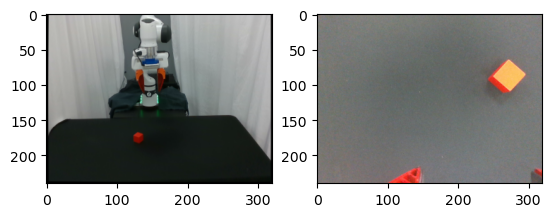

In [ ]:
data = get_imgs()
print('keys: ', data.keys())

img_wrist = data['camera_0_color']
img_front = data['camera_1_color']

agentview_rgb=img_wrist 
eye_in_hand_rgb=img_front
print(eye_in_hand_rgb.shape)

# new= eye_in_hand_rgb.transpose(0, 1, 2)

plt.subplot(121)
plt.imshow(agentview_rgb[:,:,::-1])
plt.subplot(122)
plt.imshow(eye_in_hand_rgb[:,:,::-1])

In [ ]:
def get_current_obs(robot_interface):
    last_state = robot_interface._state_buffer[-1]
    # print(last_state)
    last_gripper_state = robot_interface._gripper_state_buffer[-1]
    
    obs_dict = raw_obs_dict_generator.get_raw_obs_dict(
    {"last_state": last_state, "last_gripper_state": last_gripper_state})
    # obs_dict={} #rgb only 

    data = get_imgs()
    img_wrist = data['camera_0_color']
    img_front = data['camera_1_color']

    agentview_rgb=img_wrist
    eye_in_hand_rgb=img_front
    # eye_in_hand_rgb[:, :, [0, 2]] = eye_in_hand_rgb[:, :, [2, 0]]
    # agentview_rgb=cv2.resize(img_wrist, (120, 120))  
    # eye_in_hand_rgb=cv2.resize(img_front, (120, 120)) 

    # agentview_rgb.shape, eye_in_hand_rgb.shape

    obs_dict['agentview_rgb']=agentview_rgb.transpose(2, 1, 0)
    obs_dict['eye_in_hand_rgb']=eye_in_hand_rgb.transpose(2, 1, 0)
    return obs_dict

obs_dict=get_current_obs(robot_interface)
for key in obs_dict.keys():
    obs_dict[key]=obs_dict[key][None]
    print(key, obs_dict[key].shape)

ee_states (1, 16)
joint_states (1, 7)
gripper_states (1, 1)
agentview_rgb (1, 3, 320, 240)
eye_in_hand_rgb (1, 3, 320, 240)


In [ ]:

# checkpoint = '/home/franka_deoxys/train_dp_bg_removed/after_train_500_epochs.ckpt'
# checkpoint= '/home/franka_deoxys/riad/diffusion_policy/duck_train/epoch_400_20250227_225952.ckpt'
# checkpoint= '/home/franka_deoxys/riad/after_train_100_epochs.ckpt'
# checkpoint = '/home/franka_deoxys/riad/duck_65_checkpoint/after_train_300_epochs.ckpt'
# checkpoint = '/home/franka_deoxys/riad/duck_50_checkpoint/after_train_150_epochs.ckpt'
# checkpoint= '/home/franka_deoxys/riad/duck_56_checkpoint/after_train_300_epochs.ckpt'
# checkpoint = '/home/franka_deoxys/riad/duck_92_checkpoints/densed/after_train_200_epochs.ckpt'
# checkpoint = '/home/franka_deoxys/riad/duck_36_checkpoints/after_train_150_epochs.ckpt'
# checkpoint = '/home/franka_deoxys/riad/duck_36_checkpoints/new_15_3_25/after_train_400_epochs.ckpt'
# checkpoint = '/home/franka_deoxys/riad/duck_92_checkpoints/new_15_03_25/epoch_400_20250315_054547.ckpt'
# checkpoint= '/home/franka_deoxys/riad/candy_35/after_train_200_epochs.ckpt' # candy
# checkpoint = '/home/franka_deoxys/riad/candy_75/epoch_200_20250319_212844.ckpt' #candy
# checkpoint = '/home/franka_deoxys/riad/candy_75/after_train_300_epochs.ckpt' #candy
# checkpoint = '/home/franka_deoxys/riad/block/after_train_200_epochs.ckpt' # block
checkpoint = '/home/franka_deoxys/riad/block/both_views/epoch_100_20250320_221135.ckpt' #block both view
payload = torch.load(open(checkpoint, 'rb'), pickle_module=dill)
cfg = payload['cfg'] 
workspace = TrainDiffusionUnetHybridWorkspace(cfg, output_dir=None)
workspace: BaseWorkspace
workspace.load_payload(payload, exclude_keys=None, include_keys=None)


============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['ee_states', 'gripper_states', 'joint_states']
using obs modality: rgb with keys: ['eye_in_hand_rgb', 'agentview_rgb']
using obs modality: depth with keys: []
using obs modality: scan with keys: []


/home/franka_deoxys/miniconda3/envs/robodiff_2/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/franka_deoxys/miniconda3/envs/robodiff_2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Diffusion params: 6.735348e+07
Vision params: 2.239418e+07


In [ ]:
# get policy from workspace
policy = workspace.model
if cfg.training.use_ema:
    policy = workspace.ema_model

device = torch.device(device)
policy.to(device)
policy.eval()
pass 

In [ ]:
rotation_transformer = RotationTransformer('axis_angle', 'rotation_6d')

def undo_transform_action( action):
    raw_shape = action.shape
    if raw_shape[-1] == 20:
        # dual arm
        action = action.reshape(-1,2,10)

    d_rot = action.shape[-1] - 4
    pos = action[...,:3]
    rot = action[...,3:3+d_rot]
    gripper = action[...,[-1]]
    rot = rotation_transformer.inverse(rot)
    uaction = np.concatenate([
        pos, rot, gripper
    ], axis=-1)

    if raw_shape[-1] == 20:
        # dual arm
        uaction = uaction.reshape(*raw_shape[:-1], 14)

    return uaction


def predict_action(obs):
    """ 
    obs: 2x...
    """
    np_obs_dict = {key:obs[key] for key in keys_select}
    obs_dict = dict_apply(np_obs_dict, 
        lambda x: torch.from_numpy(x).to(
            device=device))

    for key in obs_dict.keys():
        obs_dict[key]=obs_dict[key].unsqueeze(0) 

    
    with torch.no_grad():
        
        action_dict = policy.predict_action(obs_dict)

    # device_transfer
    np_action_dict = dict_apply(action_dict, lambda x: x.detach().to('cpu').numpy())


    # step env
    env_action =  np_action_dict['action']
    env_action = undo_transform_action(env_action)

    env_action=env_action.squeeze()
    return env_action

In [ ]:
framestacker=FrameStackForTrans(2)
keys_select = ['agentview_rgb', 'joint_states', 'ee_states', 'eye_in_hand_rgb', 'gripper_states']
# keys_select = ['eye_in_hand_rgb', 'gripper_states']

obs_dict=get_current_obs(robot_interface)
for key in obs_dict.keys(): 
    print(key, obs_dict[key].shape)

# keys_select = [ 'joint_states', 'ee_states', 'eye_in_hand_rgb', 'gripper_states']
framestacker=FrameStackForTrans(2) 
policy.reset()

obs_dict=get_current_obs(robot_interface)
obs = framestacker.reset(obs_dict)
obs_dict=get_current_obs(robot_interface)
obs = framestacker.add_new_obs(obs_dict)

# plt.subplot(121)
# plt.imshow(obs['eye_in_hand_rgb'][0].transpose(1,2,0))

# plt.subplot(122)
# plt.imshow(obs['eye_in_hand_rgb'][1].transpose(1,2,0))
action_pred=predict_action(obs)
action_pred

ee_states (16,)
joint_states (7,)
gripper_states (1,)
agentview_rgb (3, 320, 240)
eye_in_hand_rgb (3, 320, 240)


array([[-0.   , -0.133, -0.142,  0.012, -0.024, -0.002, -1.   ],
       [ 0.029, -0.121, -0.145,  0.018, -0.007, -0.012, -0.979],
       [ 0.067, -0.122, -0.162, -0.008, -0.017, -0.013, -0.992],
       [ 0.057, -0.116, -0.156,  0.005, -0.018, -0.014, -1.   ],
       [ 0.082, -0.111, -0.179, -0.006, -0.034, -0.023, -1.   ],
       [ 0.075, -0.079, -0.172, -0.013, -0.022, -0.015, -0.998],
       [ 0.085, -0.049, -0.19 , -0.01 , -0.027, -0.01 , -0.986],
       [ 0.1  , -0.018, -0.178, -0.022, -0.025, -0.015, -0.993]],
      dtype=float32)

In [1]:
reset_joint_positions_b= [0.034,0.109,-0.012,-1.63,0.005,1.776,0.696]

In [2]:
# # reset robot
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions_b)
set_gripper(open=True)


NameError: name 'set_gripper' is not defined

In [ ]:
framestacker=FrameStackForTrans(2) 
policy.reset()
obs_dict=get_current_obs(robot_interface)
obs = framestacker.reset(obs_dict)
obs_dict=get_current_obs(robot_interface)
obs = framestacker.add_new_obs(obs_dict)
# policy.reset()
# # reset robot
images = []
all_poses_7d = []
all_inside_flags = []

for _ in range(1000):
    # 1) Acquire user input
    # action, grasp = input2action(device=spacemouse, controller_type=controller_type)
    # if action is None:
    #     break
    if len(robot_interface._state_buffer) == 0:
        continue

    # 2) Get observation
    obs_dict = get_current_obs(robot_interface)
    img = obs_dict['eye_in_hand_rgb']
    # img = img.transpose(2, 1, 0)
    print(img.shape)
    # plt.subplot(111)
    # plt.imshow(img)
    images.append(img)
    obs = framestacker.add_new_obs(obs_dict)
    # print(obs)

    # 3) Policy predicts an action (whatever format: delta pose, EEF pose, etc.)
    #    We'll send it to the robot
    action_pred = predict_action(obs)  # shape is up to your policy
    # print("Raw policy prediction:", action_pred)

    

    # 4) Let's say we control the robot with the first 4 predicted actions
    for i, single_cmd in enumerate(action_pred):
        print(f"action {i} =>", single_cmd)
        robot_interface.control(
            controller_type=controller_type,
            action=single_cmd,
            controller_cfg=controller_cfg,
        )

        # (Optional) short delay for the robot to move
        time.sleep(0.08)

        # 5) Now read the *actual* real joint angles from the robot
        #    e.g. shape (7,) => [q1, q2, q3, q4, q5, q6, q7]
        js_real = robot_interface.last_q  
        if js_real is None:
            print("No joint angles read. Skipping.")
            continue

        # # 6) Convert those real joints => 7D EEF pose => 6D => safe-set check
        # eef_pose_7d = joint_angles_to_end_effector_pose(js_real)  # shape (7,)
        # eef_pose_6d = pose7d_to_6d(eef_pose_7d)
        # inside, distances = is_pose_in_safe_set_6d(eef_pose_6d, hull_equations, tol=1e-1)

        # # print(f"   => Real Joints {js_real}, EEF pose {eef_pose_7d}")
        # print(f"   => inside={inside}, distances={distances}")

        # # 7) Collect for final visualization
        # all_poses_7d.append(eef_pose_7d)
        # all_inside_flags.append(inside)

robot_interface.close()

In [3]:

# Parse robot configuration and create robot interface.
args = robot_config_parse_args()
robot_interface = FrankaInterface(os.path.join(config_root, args.interface_cfg))
controller_cfg = YamlConfig(os.path.join(config_root, args.controller_cfg)).as_easydict()
controller_type = args.controller_type


In [4]:
# Initialize SpaceMouse (using new wireless IDs).
from deoxys.utils.io_devices import SpaceMouse
spacemouse = SpaceMouse(vendor_id=9583, product_id=50770)
spacemouse.start_control()

raw_obs_dict_generator = RobotStateRawObsDictGenerator()

Opening SpaceMouse device
Manufacturer: 3Dconnexion
Product: 3Dconnexion Universal Receiver

Control                       	Command
Right button                  	reset simulation
Left button (hold)            	close gripper
Move mouse laterally          	move arm horizontally in x-y plane
Move mouse vertically         	move arm vertically
Twist mouse about an axis     	rotate arm about a corresponding axis
ESC                           	quit



In [5]:

def set_gripper(open=True):
    # Use -1 for open, 1 for closed.
    d = -1.0 if open else 1.0
    action_close = np.array([0., 0., 0., 0., 0., 0., d])
    robot_interface.control(
        controller_type=controller_type,
        action=action_close,
        controller_cfg=controller_cfg,
    )

# Check robot state buffer.
if not robot_interface._state_buffer:
    print("The state buffer is empty.")

# --- Setup Camera Interfaces ---
camera_ids = [0, 1]
cr_interfaces = {}
use_depth = False
for camera_id in camera_ids:
    camera_ref = f"rs_{camera_id}"
    assert_camera_ref_convention(camera_ref)
    camera_info = get_camera_info(camera_ref)
    print("Camera Info:", camera_info)
    cr_interface = CameraRedisSubInterface(camera_info=camera_info, use_depth=use_depth, redis_host='127.0.0.1')
    cr_interface.start()
    cr_interfaces[camera_id] = cr_interface

def get_imgs(use_depth=False):
    data = {}
    for camera_id in camera_ids:
        img_info = cr_interfaces[camera_id].get_img_info()
        data[f"camera_{camera_id}"] = img_info

        imgs = cr_interfaces[camera_id].get_img()
        # Convert BGR to RGB (if necessary) and resize.
        color_img = imgs["color"][..., ::-1]
        color_img = cv2.resize(color_img, (320, 240))
        data[f"camera_{camera_id}_color"] = color_img

        if use_depth:
            depth_img = imgs["depth"]
            depth_img = cv2.resize(depth_img, (224, 224))
            data[f"camera_{camera_id}_depth"] = depth_img
    return data

Camera Info: {'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'}
CameraRedisSubInterface:: {'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'} True False
Camera Info: {'camera_id': 1, 'camera_type': 'rs', 'camera_name': 'camera_rs_1'}
CameraRedisSubInterface:: {'camera_id': 1, 'camera_type': 'rs', 'camera_name': 'camera_rs_1'} True False


Camera keys: dict_keys(['camera_0', 'camera_0_color', 'camera_1', 'camera_1_color'])


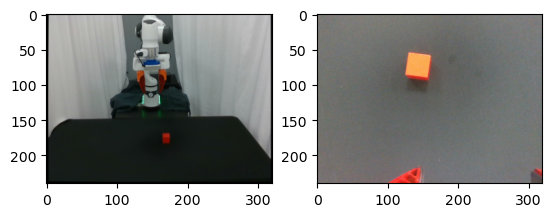

In [6]:


# Display images from cameras for debugging.
data = get_imgs()
print("Camera keys:", data.keys())
img_wrist = data['camera_0_color']
img_front = data['camera_1_color']
plt.subplot(121), plt.imshow(img_wrist[:,:,::-1])
plt.subplot(122), plt.imshow(img_front[:,:,::-1])
plt.show()

In [29]:
def get_current_obs(robot_interface):
    # Get the latest robot state.
    last_state = robot_interface._state_buffer[-1]
    last_gripper_state = robot_interface._gripper_state_buffer[-1]
    obs_dict = raw_obs_dict_generator.get_raw_obs_dict({
        "last_state": last_state, "last_gripper_state": last_gripper_state
    })
    # Get images from cameras.
    data = get_imgs()
    # Use wrist image as agent view and front image as eye-in-hand.
    agentview_rgb = data['camera_0_color']
    eye_in_hand_rgb = data['camera_1_color']
    # Transpose images if needed (here converting HxWxC to CxWxH).
    obs_dict['agentview_rgb'] = agentview_rgb.transpose(2, 0, 1)
    obs_dict['eye_in_hand_rgb'] = eye_in_hand_rgb.transpose(2, 0, 1)
    return obs_dict

# Get an initial observation and add a batch dimension.
obs_dict = get_current_obs(robot_interface)
for key in obs_dict.keys():
    obs_dict[key] = obs_dict[key][None]
    print(key, obs_dict[key].shape)

ee_states (1, 16)
joint_states (1, 7)
gripper_states (1, 1)
agentview_rgb (1, 3, 240, 320)
eye_in_hand_rgb (1, 3, 240, 320)


In [25]:

# --- Load Diffusion Policy from Checkpoint ---
checkpoint = '/home/franka_deoxys/riad/block/both_views/after_train_200_epochs.ckpt'
# Load checkpoint with dill
payload = torch.load(checkpoint, pickle_module=dill)
cfg = payload['cfg']
# Instantiate a workspace and load payload.
workspace = TrainDiffusionUnetHybridWorkspace(cfg, output_dir=None)
workspace.load_payload(payload, exclude_keys=None, include_keys=None)
# Get the policy from the workspace (use EMA if enabled).
policy = workspace.model
if cfg.training.use_ema:
    policy = workspace.ema_model
policy.to(device)
policy.eval()
pass


============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['ee_states', 'joint_states', 'gripper_states']
using obs modality: rgb with keys: ['agentview_rgb', 'eye_in_hand_rgb']
using obs modality: depth with keys: []
using obs modality: scan with keys: []
Diffusion params: 6.735348e+07
Vision params: 2.239418e+07


In [21]:
# Create a rotation transformer for undoing rotation transform.
rotation_transformer = RotationTransformer('axis_angle', 'rotation_6d')

def undo_transform_action(action):
    """Undo the transformation applied to actions (e.g., convert from rotation_6d to axis-angle)."""
    raw_shape = action.shape
    if raw_shape[-1] == 20:  # if dual arm, reshape appropriately
        action = action.reshape(-1, 2, 10)
    d_rot = action.shape[-1] - 4
    pos = action[..., :3]
    rot = action[..., 3:3+d_rot]
    gripper = action[..., [-1]]
    rot = rotation_transformer.inverse(rot)
    uaction = np.concatenate([pos, rot, gripper], axis=-1)
    if raw_shape[-1] == 20:
        uaction = uaction.reshape(*raw_shape[:-1], 14)
    return uaction

# Define keys for policy input. Adjust if your observation dictionary has different keys.
keys_select = ['agentview_rgb', 'joint_states', 'ee_states', 'eye_in_hand_rgb', 'gripper_states']

def predict_action(obs):
    """Predict action from observation.
       obs is assumed to be a dictionary with keys in keys_select.
    """
    # Select only the necessary keys.
    np_obs_dict = {key: obs[key] for key in keys_select if key in obs}
    obs_dict = dict_apply(np_obs_dict, lambda x: torch.from_numpy(x).to(device))
    # Add batch dimension if needed.
    for key in obs_dict.keys():
        # if obs_dict[key].ndim == 3:
        obs_dict[key] = obs_dict[key].unsqueeze(0)
    with torch.no_grad():
        action_dict = policy.predict_action(obs_dict)
    np_action_dict = dict_apply(action_dict, lambda x: x.detach().cpu().numpy())
    env_action = np_action_dict['action']
    env_action = undo_transform_action(env_action)
    return env_action.squeeze()

In [26]:

# Initialize framestacker (to stack two consecutive observations).
framestacker = FrameStackForTrans(2)
# (Make sure FrameStackForTrans is correctly imported from util_eval.)
policy.reset()

# Initialize observation stack.
obs_dict = get_current_obs(robot_interface)
obs = framestacker.reset(obs_dict)
# Add a new observation.
obs_dict = get_current_obs(robot_interface)
obs = framestacker.add_new_obs(obs_dict)

# Predict an action from the initial stacked observation.
action_pred = predict_action(obs)
print("Initial predicted action:", action_pred)

Initial predicted action: [[ 0.078 -0.06  -0.059 -0.003 -0.029 -0.006  0.973]
 [ 0.067 -0.045 -0.029 -0.015 -0.015 -0.006  1.   ]
 [ 0.08  -0.053 -0.004 -0.021 -0.007 -0.004  0.982]
 [ 0.059 -0.032  0.035 -0.016 -0.014 -0.003  1.   ]
 [ 0.056 -0.042  0.021 -0.011 -0.016 -0.007  1.   ]
 [ 0.035 -0.02   0.038 -0.016 -0.014 -0.005  1.   ]
 [ 0.049 -0.027  0.003 -0.018 -0.022  0.003  1.   ]
 [ 0.037 -0.009  0.021 -0.023 -0.012 -0.003  1.   ]]


In [42]:



# Reset robot joints and gripper as needed.
reset_joint_positions_b = [0.034, 0.109, -0.012, -1.63, 0.005, 1.776, 0.696]
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions_b)
set_gripper(open=True)

# Reset framestacker and policy.
framestacker = FrameStackForTrans(2)
policy.reset()
obs_dict = get_current_obs(robot_interface)
obs = framestacker.reset(obs_dict)
obs_dict = get_current_obs(robot_interface)
obs = framestacker.add_new_obs(obs_dict)

# --- Main Inference Loop ---
images = []
all_poses_7d = []
all_inside_flags = []

for _ in range(1000):
    if len(robot_interface._state_buffer) == 0:
        continue

    # Get current observation.
    obs_dict = get_current_obs(robot_interface)
    img = obs_dict['eye_in_hand_rgb']
    print("Eye-in-hand image shape:", img.shape)
    images.append(img)
    
    # Update observation stack.
    obs = framestacker.add_new_obs(obs_dict)
    
    # Predict action.
    action_pred = predict_action(obs)
    
    # Send predicted actions to the robot.
    for i, single_cmd in enumerate(action_pred[:1]):
        print(f"Sending action {i}: {single_cmd}")
        robot_interface.control(
            controller_type=controller_type,
            action=single_cmd,
            controller_cfg=controller_cfg,
        )
        time.sleep(0.08)  # Short delay for robot motion.
    
    # Optionally, read the robot's joint angles.
    js_real = robot_interface.last_q
    if js_real is None:
        print("No joint angles read. Skipping iteration.")
        continue
    
    # (Optional) Process joint angles for safety checking, logging, etc.
    # e.g., convert joint angles to end-effector pose, perform safe-set checks, etc.
    
robot_interface.close()


JOINT_POSITION
Eye-in-hand image shape: (3, 240, 320)
Sending action 0: [-0.118 -0.102 -0.102  0.009 -0.025  0.027 -0.975]
Eye-in-hand image shape: (3, 240, 320)
Sending action 0: [ 0.078 -0.001 -0.149 -0.008  0.016  0.006 -0.953]
Eye-in-hand image shape: (3, 240, 320)
Sending action 0: [ 0.057  0.051 -0.291 -0.012 -0.023  0.044 -0.984]
Eye-in-hand image shape: (3, 240, 320)
Sending action 0: [ 0.078  0.211 -0.269 -0.035 -0.023 -0.002 -0.952]
Eye-in-hand image shape: (3, 240, 320)
Sending action 0: [ 0.436 -0.12  -0.18  -0.004 -0.028 -0.033 -0.974]
Eye-in-hand image shape: (3, 240, 320)
Sending action 0: [ 0.245 -0.035 -0.167 -0.007 -0.028  0.026 -1.   ]
Eye-in-hand image shape: (3, 240, 320)
Sending action 0: [ 0.374 -0.171 -0.093  0.014  0.013  0.044 -0.986]
Eye-in-hand image shape: (3, 240, 320)
Sending action 0: [ 0.154 -0.129 -0.246 -0.    -0.035  0.049 -0.972]
Eye-in-hand image shape: (3, 240, 320)
Sending action 0: [ 0.19  -0.323 -0.166  0.018 -0.033  0.036 -0.977]
Eye-in-hand i

KeyboardInterrupt: 

In [1]:
#!/usr/bin/env python
"""
Inference script for a real Franka robot using a diffusion-based policy.

This script:
  - Initializes the robot interface and a camera interface via Redis.
  - Loads a diffusion policy checkpoint (and its training config) via TrainDiffusionUnetHybridWorkspace.
  - Processes raw observations (robot state + camera images) into the expected dictionary.
  - Uses a FrameStackForTrans to stack 2 consecutive observations.
  - Predicts actions via the diffusion policy, applies an inverse transformation, and sends commands to the robot.
  
Adjust file paths and configuration values as needed.
"""

import sys
import os
import time
import copy
import dill
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tqdm

from pathlib import Path

# Add necessary project directories to PYTHONPATH
sys.path.append("/home/franka_deoxys/diffusion_policy")
sys.path.append("/home/franka_deoxys/deoxys_control/deoxys")
sys.path.append("/home/franka_deoxys/deoxys_vision")

# Import diffusion policy workspace and utilities
from diffusion_policy.workspace.train_diffusion_unet_hybrid_workspace import TrainDiffusionUnetHybridWorkspace
from diffusion_policy.model.common.rotation_transformer import RotationTransformer
from diffusion_policy.common.pytorch_util import dict_apply

# Import deoxys robot and vision interfaces and utilities
from deoxys.franka_interface import FrankaInterface
from deoxys.utils.config_utils import robot_config_parse_args
from deoxys.utils import YamlConfig
from deoxys.experimental.motion_utils import reset_joints_to
from deoxys.utils.io_devices import SpaceMouse
from deoxys.utils.log_utils import get_deoxys_example_logger

from deoxys_vision.networking.camera_redis_interface import CameraRedisSubInterface
from deoxys_vision.utils.camera_utils import assert_camera_ref_convention, get_camera_info

# Import our evaluation utilities (for stacking observations)
from util_eval import RobotStateRawObsDictGenerator, FrameStackForTrans

# Set numpy print options
np.set_printoptions(precision=3, suppress=True)

logger = get_deoxys_example_logger()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ---------------------------
# Robot and Controller Setup
# ---------------------------
# Parse robot configuration arguments (if using command-line args; otherwise, set defaults)
args = robot_config_parse_args()  
# For inference, we fill in dummy/default values if not provided:
if not hasattr(args, 'interface_cfg'):
    args.interface_cfg = "interface_franka.yaml"  # path relative to config_root
if not hasattr(args, 'controller_cfg'):
    args.controller_cfg = "/home/franka_deoxys/deoxys_control/deoxys/config/osc-pose-controller.yml"
if not hasattr(args, 'controller_type'):
    args.controller_type = "OSC_POSE"  # or "velocity" as needed

# Use deoxys' config_root (assumed to be set properly)
from deoxys import config_root

# Instantiate robot interface.
robot_interface = FrankaInterface(os.path.join(config_root, args.interface_cfg))
controller_cfg = YamlConfig(os.path.join(config_root, args.controller_cfg)).as_easydict()
controller_type = args.controller_type

# ---------------------------
# Initialize Input Devices (e.g., SpaceMouse)
# ---------------------------
from deoxys.utils.io_devices import SpaceMouse
spacemouse = SpaceMouse(vendor_id=9583, product_id=50770)
spacemouse.start_control()

raw_obs_dict_generator = RobotStateRawObsDictGenerator()

/home/franka_deoxys/miniconda3/envs/robodiff_2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Opening SpaceMouse device
Manufacturer: 3Dconnexion
Product: 3Dconnexion Universal Receiver

Control                       	Command
Right button                  	reset simulation
Left button (hold)            	close gripper
Move mouse laterally          	move arm horizontally in x-y plane
Move mouse vertically         	move arm vertically
Twist mouse about an axis     	rotate arm about a corresponding axis
ESC                           	quit



In [ ]:


def set_gripper(open=True):
    d = -1.0 if open else 1.0
    action_close = np.array([0., 0., 0., 0., 0., 0., d])
    robot_interface.control(controller_type=controller_type,
                              action=action_close,
                              controller_cfg=controller_cfg)

# ---------------------------
# Camera Interface Setup
# ---------------------------
camera_ids = [0, 1]  # Two cameras: one for wrist (agent view) and one front (eye-in-hand)
cr_interfaces = {}
use_depth = False
for cam_id in camera_ids:
    camera_ref = f"rs_{cam_id}"
    assert_camera_ref_convention(camera_ref)
    camera_info = get_camera_info(camera_ref)
    print("Camera Info:", camera_info)
    cr_interface = CameraRedisSubInterface(camera_info=camera_info, use_depth=use_depth, redis_host='127.0.0.1')
    cr_interface.start()
    cr_interfaces[cam_id] = cr_interface

def get_imgs(use_depth=False):
    data = {}
    for cam_id in camera_ids:
        img_info = cr_interfaces[cam_id].get_img_info()
        data[f"camera_{cam_id}"] = img_info
        imgs = cr_interfaces[cam_id].get_img()
        color_img = imgs["color"][..., ::-1]  # Convert BGR to RGB
        # Resize to the expected resolution (assumed 320x240 for now; adjust if necessary)
        color_img = cv2.resize(color_img, (320, 240))
        data[f"camera_{cam_id}_color"] = color_img
        if use_depth:
            depth_img = imgs["depth"]
            depth_img = cv2.resize(depth_img, (320, 240))
            data[f"camera_{cam_id}_depth"] = depth_img
    return data

# ---------------------------
# Observation Preprocessing
# ---------------------------
def get_current_obs(robot_interface):
    # Get the latest raw robot state.
    last_state = robot_interface._state_buffer[-1]
    last_gripper_state = robot_interface._gripper_state_buffer[-1]
    obs_dict = raw_obs_dict_generator.get_raw_obs_dict({
        "last_state": last_state, 
        "last_gripper_state": last_gripper_state
    })
    # Get camera images.
    data = get_imgs()
    # Use camera 0 as agent view and camera 1 as eye-in-hand.
    img_wrist = data['camera_0_color']
    img_front = data['camera_1_color']
    # Convert from (H, W, C) to (C, H, W) assuming model expects that.
    obs_dict['agentview_rgb'] = img_wrist.transpose(2, 0, 1)
    obs_dict['eye_in_hand_rgb'] = img_front.transpose(2, 0, 1)
    return obs_dict

# Add a batch dimension to all observations.
obs_dict = get_current_obs(robot_interface)
for key in obs_dict.keys():
    obs_dict[key] = obs_dict[key][None]
    print(f"{key} shape:", obs_dict[key].shape)

# ---------------------------
# Load Diffusion Policy from Checkpoint
# ---------------------------
# Use the checkpoint path from your code.
checkpoint_path = '/home/franka_deoxys/riad/block/both_views/epoch_100_20250320_221135.ckpt'
payload = torch.load(checkpoint_path, pickle_module=dill)
cfg = payload['cfg']
# Instantiate the workspace (which builds the model) from the saved configuration.
workspace = TrainDiffusionUnetHybridWorkspace(cfg, output_dir=None)
workspace.load_payload(payload, exclude_keys=None, include_keys=None)
# Get the policy model.
policy = workspace.model
if cfg.training.use_ema:
    policy = workspace.ema_model
policy.to(device)
policy.eval()

# Create a rotation transformer (for handling rotation representations).
rotation_transformer = RotationTransformer('axis_angle', 'rotation_6d')

def undo_transform_action(action):
    raw_shape = action.shape
    if raw_shape[-1] == 20:
        action = action.reshape(-1, 2, 10)
    d_rot = action.shape[-1] - 4
    pos = action[..., :3]
    rot = action[..., 3:3+d_rot]
    gripper = action[..., [-1]]
    # Inverse transform: convert from 6D representation back to axis-angle.
    rot = rotation_transformer.inverse(rot)
    uaction = np.concatenate([pos, rot, gripper], axis=-1)
    if raw_shape[-1] == 20:
        uaction = uaction.reshape(*raw_shape[:-1], 14)
    return uaction

# Define keys for policy input. (Ensure these match what was used during training.)
keys_select = ['agentview_rgb', 'joint_states', 'ee_states', 'eye_in_hand_rgb', 'gripper_states']





Camera Info: {'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'}
CameraRedisSubInterface:: {'camera_id': 0, 'camera_type': 'rs', 'camera_name': 'camera_rs_0'} True False
Camera Info: {'camera_id': 1, 'camera_type': 'rs', 'camera_name': 'camera_rs_1'}
CameraRedisSubInterface:: {'camera_id': 1, 'camera_type': 'rs', 'camera_name': 'camera_rs_1'} True False
ee_states shape: (1, 16)
joint_states shape: (1, 7)
gripper_states shape: (1, 1)
agentview_rgb shape: (1, 3, 240, 320)
eye_in_hand_rgb shape: (1, 3, 240, 320)

============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['joint_states', 'gripper_states', 'ee_states']
using obs modality: rgb with keys: ['eye_in_hand_rgb', 'agentview_rgb']
using obs modality: depth with keys: []
using obs modality: scan with keys: []


/home/franka_deoxys/miniconda3/envs/robodiff_2/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/franka_deoxys/miniconda3/envs/robodiff_2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Diffusion params: 6.735348e+07
Vision params: 2.239418e+07


In [4]:
def predict_action(obs):
    # Ensure required keys exist. Fill missing keys with dummy data.
    required_keys = ['agentview_rgb', 'joint_states', 'ee_states', 'eye_in_hand_rgb', 'gripper_states']
    # Assume default shapes; adjust these as per your training:
    default_shapes = {
        'joint_states': (7,),     # e.g., 7 joint angles
        'ee_states': (6,),        # e.g., 6-dim end-effector pose
        'gripper_states': (1,)    # e.g., one gripper state value
    }
    np_obs_dict = {}
    for key in required_keys:
        if key in obs:
            np_obs_dict[key] = obs[key]
        else:
            if key in default_shapes:
                # Create a zero vector for missing low-dim keys.
                np_obs_dict[key] = np.zeros(default_shapes[key], dtype=np.float32)
            else:
                # For images, you might have a default black image (3,84,84)
                np_obs_dict[key] = np.zeros((3,84,84), dtype=np.float32)
    
    obs_tensor = dict_apply(np_obs_dict, lambda x: torch.from_numpy(x).to(device))
    for key in obs_tensor.keys():
        if isinstance(obs_tensor[key], torch.Tensor) and obs_tensor[key].ndim == 3:
            obs_tensor[key] = obs_tensor[key].unsqueeze(0)
    with torch.no_grad():
        action_dict = policy.predict_action(obs_tensor)
    np_action_dict = dict_apply(action_dict, lambda x: x.detach().cpu().numpy())
    env_action = np_action_dict['action']
    env_action = undo_transform_action(env_action)
    return env_action.squeeze()

In [5]:

# ---------------------------
# FrameStacking (to stack 2 consecutive observations)
# ---------------------------
framestacker = FrameStackForTrans(2)
policy.reset()
obs_dict = get_current_obs(robot_interface)
obs = framestacker.reset(obs_dict)
obs_dict = get_current_obs(robot_interface)
obs = framestacker.add_new_obs(obs_dict)

# Test an initial prediction.
action_pred = predict_action(obs)
print("Initial predicted action:", action_pred)

# ---------------------------
# Reset Robot Before Inference
# ---------------------------
reset_joint_positions_b = [0.034, 0.109, -0.012, -1.63, 0.005, 1.776, 0.696]
set_gripper(open=True)
reset_joints_to(robot_interface, reset_joint_positions_b)
set_gripper(open=True)

# Reinitialize framestacker and policy for a new episode.
framestacker = FrameStackForTrans(2)
policy.reset()
obs_dict = get_current_obs(robot_interface)
obs = framestacker.reset(obs_dict)
obs_dict = get_current_obs(robot_interface)
obs = framestacker.add_new_obs(obs_dict)




AssertionError: 

In [7]:
import torch
import numpy as np

def add_batch_dim(obs):
    """
    Ensure that each value in the observation dictionary has a batch dimension.
    If a numpy array has 1 or 3 dimensions (e.g. a vector or an image in (C,H,W) format),
    add a batch dimension at index 0.
    """
    new_obs = {}
    for key, value in obs.items():
        if isinstance(value, np.ndarray):
            # If shape is 1D (e.g. (N,)) or 3D (e.g. (C, H, W)), add batch dim.
            if value.ndim in [1, 3]:
                new_obs[key] = value[None, ...]
            else:
                new_obs[key] = value
        else:
            new_obs[key] = value
    return new_obs

def debug_obs_shapes(obs):
    """
    Convert each value in obs to a torch.Tensor (if not already)
    and print its shape.
    """
    for key, value in obs.items():
        if isinstance(value, np.ndarray):
            tensor_val = torch.from_numpy(value)
        elif torch.is_tensor(value):
            tensor_val = value
        else:
            print(f"Key '{key}' is of type {type(value)}; cannot determine shape.")
            continue
        print(f"{key}: shape {tensor_val.shape}")

# Example usage:
# Assume get_current_obs(robot_interface) returns a dictionary of numpy arrays.
obs = get_current_obs(robot_interface)
# Add batch dimensions where needed.
obs = add_batch_dim(obs)
# Debug: print the shape of each observation.
debug_obs_shapes(obs)

# Now you can call predict_action with these observations.
action_pred = predict_action(obs)
print("Predicted action:", action_pred)


ee_states: shape torch.Size([1, 16])
joint_states: shape torch.Size([1, 7])
gripper_states: shape torch.Size([1, 1])
agentview_rgb: shape torch.Size([1, 3, 240, 320])
eye_in_hand_rgb: shape torch.Size([1, 3, 240, 320])


AssertionError: 

In [10]:
# --- Determine Expected Image Shape ---
try:
    # If your observation encoder has an attribute input_shape,
    # it should be a tuple like (3, height, width)
    expected_img_shape = policy.obs_encoder.input_shape  
    print("Expected image shape from obs_encoder:", expected_img_shape)
except Exception as e:
    print(e)
    # Otherwise, set a default expected shape (adjust as needed)
    expected_img_shape = (3, 240, 320)
    print("Using default expected image shape:", expected_img_shape)

# --- Update get_imgs() to resize to expected dimensions ---
def get_imgs(use_depth=False):
    data = {}
    for cam_id in camera_ids:
        img_info = cr_interfaces[cam_id].get_img_info()
        data[f"camera_{cam_id}"] = img_info
        imgs = cr_interfaces[cam_id].get_img()
        color_img = imgs["color"][..., ::-1]  # Convert from BGR to RGB
        
        # Resize to the expected size.
        expected_w = expected_img_shape[2]
        expected_h = expected_img_shape[1]
        color_img = cv2.resize(color_img, (expected_w, expected_h))
        data[f"camera_{cam_id}_color"] = color_img
        
        if use_depth:
            depth_img = imgs["depth"]
            depth_img = cv2.resize(depth_img, (expected_w, expected_h))
            data[f"camera_{cam_id}_depth"] = depth_img
    return data

# --- Update get_current_obs() ---
def get_current_obs(robot_interface):
    last_state = robot_interface._state_buffer[-1]
    last_gripper_state = robot_interface._gripper_state_buffer[-1]
    obs_dict = raw_obs_dict_generator.get_raw_obs_dict({
        "last_state": last_state, 
        "last_gripper_state": last_gripper_state
    })
    data = get_imgs(use_depth=use_depth)
    # Use camera 0 as agent view and camera 1 as eye-in-hand.
    img_wrist = data['camera_0_color']
    img_front = data['camera_1_color']
    # Transpose from (H, W, C) to (C, H, W) 
    obs_dict['agentview_rgb'] = img_wrist.transpose(2, 0, 1)
    obs_dict['eye_in_hand_rgb'] = img_front.transpose(2, 0, 1)
    return obs_dict

# --- Debug Print the Observation Shapes ---
obs = get_current_obs(robot_interface)
for key in obs:
    # Check shape of each observation item
    if isinstance(obs[key], np.ndarray):
        print(f"{key}: shape {obs[key].shape}")
    else:
        print(f"{key}: type {type(obs[key])}")

# Continue with adding batch dimensions if needed and calling predict_action...
obs = {}
for key, value in get_current_obs(robot_interface).items():
    if isinstance(value, np.ndarray) and value.ndim in [1, 3]:
        obs[key] = value[None, ...]
    else:
        obs[key] = value

debug_shapes = {}
for key, value in obs.items():
    if isinstance(value, np.ndarray):
        debug_shapes[key] = value.shape
        print(f"After add_batch_dim, {key}: shape {value.shape}")

# Now call predict_action
action_pred = predict_action(obs)
print("Initial predicted action:", action_pred)


'ObservationEncoder' object has no attribute 'input_shape'
Using default expected image shape: (3, 240, 320)
ee_states: shape (16,)
joint_states: shape (7,)
gripper_states: shape (1,)
agentview_rgb: shape (3, 240, 320)
eye_in_hand_rgb: shape (3, 240, 320)
After add_batch_dim, ee_states: shape (1, 16)
After add_batch_dim, joint_states: shape (1, 7)
After add_batch_dim, gripper_states: shape (1, 1)
After add_batch_dim, agentview_rgb: shape (1, 3, 240, 320)
After add_batch_dim, eye_in_hand_rgb: shape (1, 3, 240, 320)


AssertionError: 

In [13]:
policy.obs_encoder

ObservationEncoder(
    Key(
        name=agentview_rgb
        shape=[3, 240, 320]
        modality=rgb
        randomizer=CropRandomizer(input_shape=[3, 240, 320], crop_size=[180, 180], num_crops=1)
        net=VisualCore(
          input_shape=[3, 180, 180]
          output_shape=[64]
          backbone_net=ResNet18Conv(input_channel=3, input_coord_conv=False)
          pool_net=SpatialSoftmax(num_kp=32, temperature=1.0, noise=0.0)
        )
        sharing_from=None
    )
    Key(
        name=ee_states
        shape=[16]
        modality=low_dim
        randomizer=None
        net=None
        sharing_from=None
    )
    Key(
        name=joint_states
        shape=[7]
        modality=low_dim
        randomizer=None
        net=None
        sharing_from=None
    )
    Key(
        name=eye_in_hand_rgb
        shape=[3, 240, 320]
        modality=rgb
        randomizer=CropRandomizer(input_shape=[3, 240, 320], crop_size=[180, 180], num_crops=1)
        net=VisualCore(
          in

In [14]:
def center_crop(img, crop_size=(180, 180)):
    """
    Center-crop an image to the given (height, width).
    Assumes img is a numpy array of shape (H, W, C).
    """
    h, w, _ = img.shape
    ch, cw = crop_size
    start_h = (h - ch) // 2
    start_w = (w - cw) // 2
    return img[start_h:start_h+ch, start_w:start_w+cw, :]

def debug_image_shapes():
    # Get raw images from cameras using your get_imgs() function.
    data = get_imgs(use_depth=False)
    original_agent = data['camera_0_color']
    original_eye = data['camera_1_color']
    print("Original agentview_rgb shape:", original_agent.shape)
    print("Original eye_in_hand_rgb shape:", original_eye.shape)
    
    # Apply center crop.
    cropped_agent = center_crop(original_agent, (180, 180))
    cropped_eye = center_crop(original_eye, (180, 180))
    print("Cropped agentview_rgb shape:", cropped_agent.shape)
    print("Cropped eye_in_hand_rgb shape:", cropped_eye.shape)
    
    # Transpose to (C, H, W)
    agent_tensor = cropped_agent.transpose(2, 0, 1)
    eye_tensor = cropped_eye.transpose(2, 0, 1)
    print("Final agentview_rgb tensor shape:", agent_tensor.shape)
    print("Final eye_in_hand_rgb tensor shape:", eye_tensor.shape)

    # Also, incorporate these into your observation dictionary
    obs = get_current_obs(robot_interface)  # if get_current_obs uses original images, update it accordingly
    # Overwrite the image entries with cropped versions for debugging:
    obs['agentview_rgb'] = cropped_agent.transpose(2, 0, 1)
    obs['eye_in_hand_rgb'] = cropped_eye.transpose(2, 0, 1)
    
    print("Observation dictionary shapes:")
    for key, value in obs.items():
        print(f"  {key}: {value.shape}")

# Call the debug function
debug_image_shapes()


Original agentview_rgb shape: (240, 320, 3)
Original eye_in_hand_rgb shape: (240, 320, 3)
Cropped agentview_rgb shape: (180, 180, 3)
Cropped eye_in_hand_rgb shape: (180, 180, 3)
Final agentview_rgb tensor shape: (3, 180, 180)
Final eye_in_hand_rgb tensor shape: (3, 180, 180)
Observation dictionary shapes:
  ee_states: (16,)
  joint_states: (7,)
  gripper_states: (1,)
  agentview_rgb: (3, 180, 180)
  eye_in_hand_rgb: (3, 180, 180)


In [17]:
def get_current_obs(robot_interface):
    last_state = robot_interface._state_buffer[-1]
    last_gripper_state = robot_interface._gripper_state_buffer[-1]
    obs_dict = raw_obs_dict_generator.get_raw_obs_dict({
        "last_state": last_state, 
        "last_gripper_state": last_gripper_state
    })
    data = get_imgs(use_depth=use_depth)
    # Instead of center cropping, just resize the raw images to the input shape expected by the randomizer.
    # The printed observation encoder indicates that input_shape should be [3, 240, 320].
    img_wrist = cv2.resize(data['camera_0_color'], (320, 240))  # (240,320,3)
    img_front = cv2.resize(data['camera_1_color'], (320, 240))
    # Convert from (H, W, C) to (C, H, W)
    obs_dict['agentview_rgb'] = img_wrist.transpose(2, 0, 1)
    obs_dict['eye_in_hand_rgb'] = img_front.transpose(2, 0, 1)
    return obs_dict


In [18]:
def add_batch_dim(obs):
    new_obs = {}
    for key, value in obs.items():
        if isinstance(value, np.ndarray):
            # If the array is 1D or 3D, add a batch dimension at axis 0.
            if value.ndim in [1, 3]:
                new_obs[key] = value[None, ...]
            else:
                new_obs[key] = value
        else:
            new_obs[key] = value
    return new_obs

# Debug the observation shapes:
obs = get_current_obs(robot_interface)
print("Before adding batch dimension:")
for key, value in obs.items():
    print(f"{key}: shape {value.shape}")

obs = add_batch_dim(obs)
print("\nAfter adding batch dimension:")
for key, value in obs.items():
    print(f"{key}: shape {value.shape}")


Before adding batch dimension:
ee_states: shape (16,)
joint_states: shape (7,)
gripper_states: shape (1,)
agentview_rgb: shape (3, 240, 320)
eye_in_hand_rgb: shape (3, 240, 320)

After adding batch dimension:
ee_states: shape (1, 16)
joint_states: shape (1, 7)
gripper_states: shape (1, 1)
agentview_rgb: shape (1, 3, 240, 320)
eye_in_hand_rgb: shape (1, 3, 240, 320)


In [27]:
def add_batch_and_time_dim(obs):
    """
    For each key in the observation dictionary:
      - Convert numpy arrays to torch.Tensor (if needed),
      - Ensure a batch dimension exists,
      - Ensure a time dimension exists (at axis=1).
    """
    new_obs = {}
    for key, value in obs.items():
        # Convert to tensor if necessary.
        if isinstance(value, np.ndarray):
            tensor_val = torch.from_numpy(value)
        elif torch.is_tensor(value):
            tensor_val = value
        else:
            print(f"Warning: key '{key}' is of type {type(value)}; skipping.")
            continue
        # If the tensor is 1D or 3D, add a batch dimension.
        if tensor_val.ndim in [1, 3]:
            tensor_val = tensor_val.unsqueeze(0)
        # If tensor now has shape (B, D) or (B, C, H, W), add a time dimension at axis=1.
        if tensor_val.ndim == 2 or tensor_val.ndim == 4:
            tensor_val = tensor_val.unsqueeze(1)
        new_obs[key] = tensor_val
    return new_obs

def ensure_time_steps(obs, T=2):
    """
    For each key in the observation dictionary, if the tensor's time dimension (axis 1)
    is less than T, repeat along that dimension until it has T time steps.
    """
    new_obs = {}
    for key, tensor in obs.items():
        if torch.is_tensor(tensor):
            current_T = tensor.shape[1]  # time dimension is at axis=1
            if current_T < T:
                repeats = [1] * tensor.ndim
                repeats[1] = T // current_T
                new_obs[key] = tensor.repeat(*repeats)
            else:
                new_obs[key] = tensor
        else:
            new_obs[key] = tensor
    return new_obs

# After you add batch and time dimensions:
obs = add_batch_and_time_dim(get_current_obs(robot_interface))
print("Shapes after add_batch_and_time_dim:")
for key, tensor in obs.items():
    print(f"  {key}: {tensor.shape}")

# Ensure all keys have T=2 time steps:
obs = ensure_time_steps(obs, T=2)
print("\nShapes after ensuring time steps = 2:")
for key, tensor in obs.items():
    print(f"  {key}: {tensor.shape}")

# Now call predict_action:
try:
    action_pred = predict_action(obs)
    print("Predicted action:", action_pred)
except Exception as e:
    print("Error during predict_action:", e)
    for key, tensor in obs.items():
        print(f"{key}: shape {tensor.shape}, dtype {tensor.dtype}")



Shapes after add_batch_and_time_dim:
  ee_states: torch.Size([1, 1, 16])
  joint_states: torch.Size([1, 1, 7])
  gripper_states: torch.Size([1, 1, 1])
  agentview_rgb: torch.Size([1, 1, 3, 240, 320])
  eye_in_hand_rgb: torch.Size([1, 1, 3, 240, 320])

Shapes after ensuring time steps = 2:
  ee_states: torch.Size([1, 2, 16])
  joint_states: torch.Size([1, 2, 7])
  gripper_states: torch.Size([1, 2, 1])
  agentview_rgb: torch.Size([1, 2, 3, 240, 320])
  eye_in_hand_rgb: torch.Size([1, 2, 3, 240, 320])
Error during predict_action: Sizes of tensors must match except in dimension 1. Expected size 2 but got size 1 for tensor number 1 in the list.
ee_states: shape torch.Size([1, 2, 16]), dtype torch.float32
joint_states: shape torch.Size([1, 2, 7]), dtype torch.float32
gripper_states: shape torch.Size([1, 2, 1]), dtype torch.float32
agentview_rgb: shape torch.Size([1, 2, 3, 240, 320]), dtype torch.float32
eye_in_hand_rgb: shape torch.Size([1, 2, 3, 240, 320]), dtype torch.float32


In [2]:
# ---------------------------
# Main Inference Loop
# ---------------------------
print("Starting main inference loop...")
for _ in range(1000):
    if len(robot_interface._state_buffer) == 0:
        continue

    obs_dict = get_current_obs(robot_interface)
    print("Current eye_in_hand_rgb shape:", obs_dict['eye_in_hand_rgb'].shape)
    
    # Update the stacked observation.
    obs = framestacker.add_new_obs(obs_dict)
    
    # Predict the action.
    action_pred = predict_action(obs)
    
    # Send each action command sequentially.
    for i, single_cmd in enumerate(action_pred):
        print(f"Sending action {i}: {single_cmd}")
        robot_interface.control(
            controller_type=controller_type,
            action=single_cmd,
            controller_cfg=controller_cfg
        )
        time.sleep(0.08)  # Short delay between commands.
    
    # Optionally, read the robot's joint states for feedback.
    js_real = robot_interface.last_q
    if js_real is None:
        print("No joint angles read. Skipping iteration.")
        continue

# End the inference loop and safely close the interface.
robot_interface.close()

Starting main inference loop...
Current eye_in_hand_rgb shape: (3, 240, 320)
Sending action 0: [ 0.468 -0.119  0.045  0.03   0.025  0.042 -0.978]
Sending action 1: [ 0.457 -0.116  0.045 -0.007  0.019  0.05  -0.959]
Sending action 2: [ 0.477 -0.157  0.013 -0.004  0.039  0.048 -0.998]
Sending action 3: [ 0.451 -0.169  0.014 -0.015  0.01   0.064 -0.989]
Sending action 4: [ 0.474 -0.179 -0.03   0.01   0.02   0.065 -0.993]
Sending action 5: [ 0.451 -0.189 -0.019 -0.009  0.017  0.068 -0.996]
Sending action 6: [ 0.438 -0.184 -0.059  0.018  0.013  0.037 -0.985]
Sending action 7: [ 0.397 -0.177 -0.039 -0.02   0.008  0.053 -0.989]
Current eye_in_hand_rgb shape: (3, 240, 320)
Sending action 0: [ 0.501 -0.088 -0.112 -0.01   0.023  0.061 -1.   ]
Sending action 1: [ 0.502 -0.074 -0.11  -0.029  0.02   0.07  -0.987]
Sending action 2: [ 0.509 -0.088 -0.141 -0.022  0.044  0.116 -0.987]
Sending action 3: [ 0.466 -0.087 -0.145 -0.023  0.035  0.087 -0.994]
Sending action 4: [ 0.456 -0.085 -0.18  -0.016  0.

KeyboardInterrupt: 